## Solid earth tide

Calculate the range contribution from solid earth tide based on the [`solid`](http://geodesyworld.github.io/SOFTS/solid.htm) fortran code by Dennis Milbert, wrapped as `solid_earth_tide.py` in MintPy solid branch.

#### To-do list
+ Pass matrix from fortran to python (get the pointer from fortran to python and use np.frombuffer), i.e. [EigenLapack.hpp in fringe](https://github.com/isce-framework/fringe/blob/master/include/fringe/EigenLapack.hpp) - Piyush

In [1]:
%matplotlib inline
import os
import pickle
import numpy as np
from matplotlib import pyplot as plt
from mintpy.objects import timeseries
from mintpy.utils import ptime, readfile, utils as ut, plot as pp
from mintpy import view
plt.rcParams.update({'font.size': 12})
figsize = [9, 3]

win = 5  # half size of the window of interest
lalo = [-21.29, -69.58]; box_suffix = 'boxCL'   # box in the center left with low  altitude; box = (10,  55,  20, 70) for SenAT149
lalo = [-21.30, -67.39]; box_suffix = 'boxLR'   # box in the lower right with high altitude; box = (200, 15, 215, 30) for SenAT149

proj_name = 'SenDT156'  # SenAT149, SenDT156

proj_dir = os.path.join('/Users/yunjunz/data/Tarapaca', proj_name)
os.chdir(proj_dir)
print('Go to directory', proj_dir)

out_file = os.path.join(proj_dir, 'offset_comp', box_suffix, 'set.pickle')

Go to directory /Users/yunjunz/data/Tarapaca/SenDT156


### 1. calc solid earth tide

solid_earth_tide.py /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/timeseriesRg.h5 -g /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/geometryRadar.h5 --update
setenv: Variable name must contain alphanumeric characters.
read date list from file: /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/timeseriesRg.h5
update mode: ON
skip re-calculating and use existing file: /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/SET.h5

------------------------------------------------------------------------------
correcting relative delay for input time-series using diff.py
diff.py /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/timeseriesRg.h5 /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/SET.h5 -o /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/timeseriesRg_SET.h5
/Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/timeseriesRg.h5 - ['/Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/inputs/SET.h5'] --> /Users/yunjunz/data/Tarapaca/SenDT156/mintpyOffset/

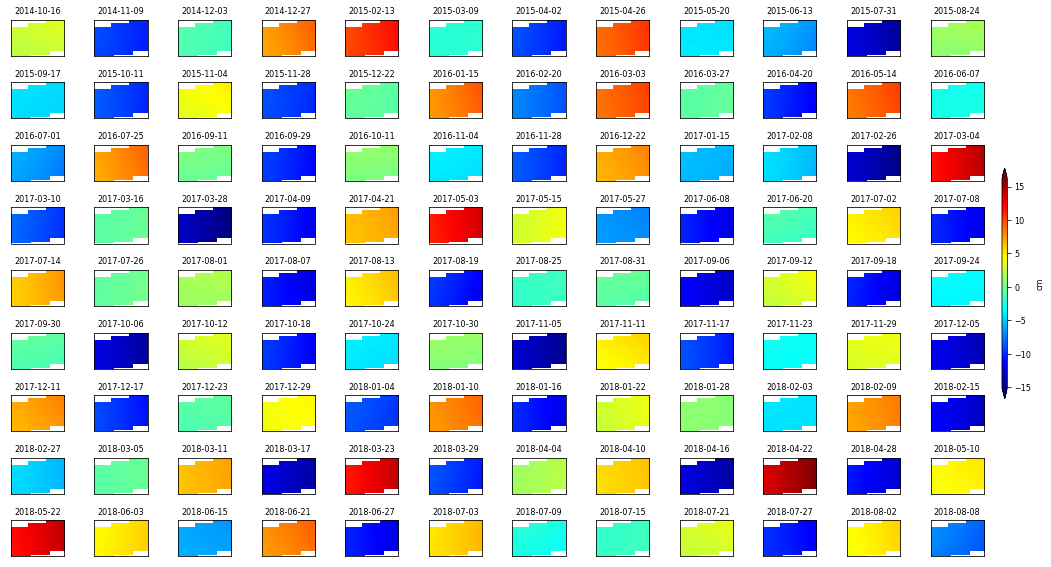

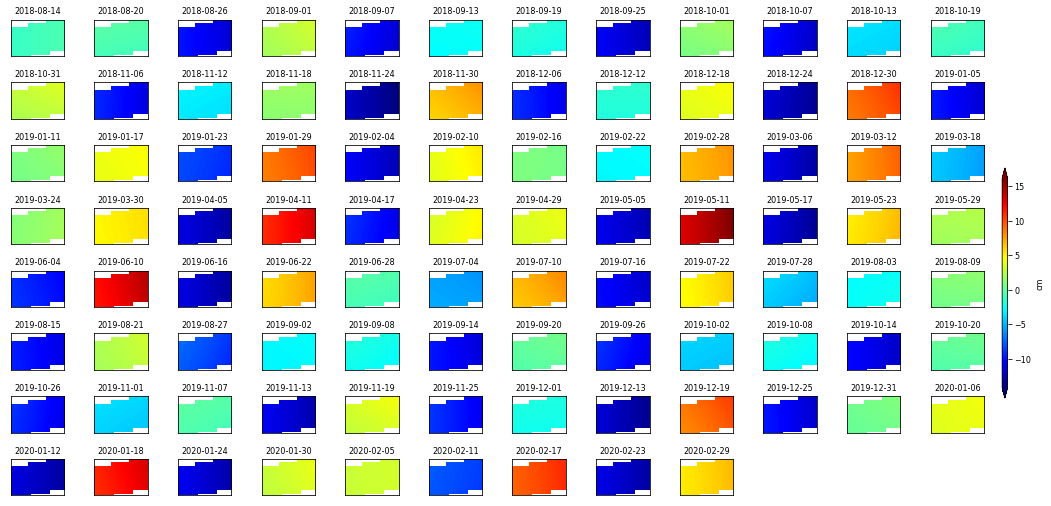

In [4]:
# I/O filename
ts_file   = os.path.join(proj_dir, 'mintpyOffset/timeseriesRg.h5')
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
set_file  = os.path.join(proj_dir, 'mintpyOffset/inputs/SET.h5')

# run command
cmd = 'solid_earth_tide.py {} -g {} --update'.format(ts_file, geom_file)
print(cmd)
!{cmd}

# display
view.main([set_file, '--noverbose'])

### 2. save to pickle file

In [5]:
# lalo --> box
atr = readfile.read_attribute(set_file)
geom_file = os.path.join(proj_dir, 'mintpyOffset/inputs/geometryRadar.h5')
coord = ut.coordinate(atr, lookup_file=geom_file)
y, x = coord.geo2radar(lalo[0], lalo[1])[:2]
box = (x-win, y-win, x+win, y+win)

# read data
date_list = timeseries(set_file).get_date_list()
num_date = len(date_list)
ts_data = readfile.read(set_file, box=box)[0].reshape(num_date, -1)

# compose set dict
sDict = {}
sDict['date'] = np.array(date_list)
sDict['time'] = np.array(ptime.date_list2vector(date_list)[0])
sDict['range_delay_SET_med'] = np.nanmedian(ts_data, axis=-1)
sDict['range_delay_SET_mad'] = ut.median_abs_deviation(ts_data)

# save to pickle file
os.makedirs(os.path.dirname(out_file), exist_ok=True)
with open(out_file, 'wb') as f:
    pickle.dump(sDict, f)
    print('save data to file: {}'.format(out_file))

save data to file: /Users/yunjunz/data/Tarapaca/SenDT156/offset_comp/boxLR/set.pickle


### 3. Plot

save figure to file /Users/yunjunz/data/Tarapaca/SenDT156/offset_comp/boxLR/set.png


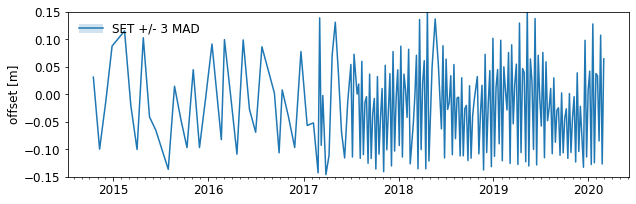

In [7]:
key_base = 'range_delay_SET'
n = 3

x = sDict['time']
y = sDict[key_base+'_med']
y_err = sDict[key_base+'_mad'] * n

fig, ax = plt.subplots(figsize=figsize)
p0, = ax.plot(x, y, linewidth=1.5, color='C0')
p1  = ax.fill_between(x, y - y_err, y + y_err, fc='C0', ec='none', alpha=0.2)

# axis format
pp.auto_adjust_xaxis_date(ax, x, every_year=1, buffer_year=None)
ax.set_ylabel('offset [m]')
ax.set_ylim(-0.15, 0.15)
ax.legend([(p0, p1)], ['SET +/- {} MAD'.format(n)], frameon=False)
fig.tight_layout()

# output
out_fig = os.path.join(os.path.dirname(out_file), 'set.png')
print('save figure to file', out_fig)
plt.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)
plt.show()